# Newell-Lee Evaporator: Rolling Horizon Simulation

Integrate the following IVP to simulate the Evaporator example from Pilario et al. (2021) in $t\in[0, 1000]$ min:

$$ \frac{dL_2}{dt} = \frac{F_1-F_4-F_2}{20}$$

$$ \frac{dX_2}{dt} = \frac{F_1 X_1 - F_2 X_2}{20} $$

$$ \frac{dP_2}{dt} = \frac{F_4 - F_5}{4} $$

Apply piecewise step changes on F200, P100, and F2 inputs every 20 min.


In [2]:
from scipy.integrate import solve_ivp
from pyomo.environ import *
from pyomo.dae import DerivativeVar, ContinuousSet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [6]:
def solve_model(ti, tf, F200data, P100data, F3data, init_data):

    evap = ConcreteModel()

    evap.ti = Param(initialize=ti)
    evap.tf = Param(initialize=tf)
    evap.t = ContinuousSet(bounds=(evap.ti,evap.tf))

    # States
    evap.L2 = Var(evap.t, initialize=1, bounds=(0, 4))
    evap.P2 = Var(evap.t, initialize=50.5)
    evap.X2 = Var(evap.t, initialize=25)

    # Manipulated variable to control L2 via P-control
    evap.F2 = Var(evap.t, initialize=2)
    
    # Inputs and Disturbances
    evap.T200 = Param(evap.t, default=25)
    evap.F1 = Param(evap.t, default=10)
    evap.X1 = Param(evap.t, default=5)
    evap.T1 = Param(evap.t, default=40)

    evap.F200 = Param(evap.t, mutable=True)  # Input to be manipulated
    evap.P100 = Param(evap.t, mutable=True)  # Input to be manipulated
    evap.F3 = Param(evap.t, mutable=True)    # Input to be manipulated

    # Other outputs
    evap.F4 = Var(evap.t, initialize=8)
    evap.F5 = Var(evap.t, initialize=8)
    evap.T2 = Var(evap.t, initialize=84.6)
    evap.T3 = Var(evap.t, initialize=80.6)
    evap.F100 = Var(evap.t, initialize=9.27)
    evap.T100 = Var(evap.t, initialize=119.9)
    evap.Q100 = Var(evap.t, initialize=339.2)
    evap.T201 = Var(evap.t, initialize=46.15)
    evap.Q200 = Var(evap.t, initialize=308)

    # Setup derivative vars for states
    evap.dL2dt = DerivativeVar(evap.L2, initialize=init_data['dL2dt'])
    evap.dP2dt = DerivativeVar(evap.P2, initialize=init_data['dP2dt'])
    evap.dX2dt = DerivativeVar(evap.X2, initialize=init_data['dX2dt'])

    # Set an objective
    evap.obj = Objective(expr=1)

    evap.z1dot = Constraint(evap.t, rule = lambda m, i: \
                           m.dL2dt[i]*20 == m.F1[i] - m.F4[i] - m.F2[i])
    evap.z2dot = Constraint(evap.t, rule = lambda m, i: \
                           m.dX2dt[i]*20 == m.F1[i]*m.X1[i] - m.F2[i]*m.X2[i])
    evap.z3dot = Constraint(evap.t, rule = lambda m, i: \
                           m.dP2dt[i]*4 == m.F4[i] - m.F5[i])

    # Other constraints
    evap.con1 = Constraint(evap.t, rule = lambda m, i: \
                          m.T2[i] == 0.5616*m.P2[i] + 0.3126*m.X2[i] + 48.43)
    evap.con2 = Constraint(evap.t, rule = lambda m, i: \
                          m.T3[i] == 0.507*m.P2[i] + 55)
    evap.con3 = Constraint(evap.t, rule = lambda m, i: \
                          m.F4[i]*38.5 == m.Q100[i] - 0.07*m.F1[i]*(m.T2[i] - m.T1[i]))
    evap.con4 = Constraint(evap.t, rule = lambda m, i: \
                          m.T100[i] == 0.1538*m.P100[i] + 90)
    evap.con5 = Constraint(evap.t, rule = lambda m, i: \
                          m.Q100[i] == 0.16*(m.F1[i] + m.F3[i])*(m.T100[i] - m.T2[i]))
    evap.con6 = Constraint(evap.t, rule = lambda m, i: \
                          m.F100[i]*36.6 == m.Q100[i])
    evap.con7 = Constraint(evap.t, rule = lambda m, i: \
                          m.Q200[i]*(0.14*m.F200[i]+6.84) == 0.9576*m.F200[i]*(m.T3[i]-m.T200[i]))
    evap.con8 = Constraint(evap.t, rule = lambda m, i:\
                          m.T201[i] == m.T200[i] + m.Q200[i]/0.07/m.F200[i])
    evap.con9 = Constraint(evap.t, rule = lambda m, i: \
                          m.F5[i]*38.5 == m.Q200[i])

    def _init(m):
        yield m.L2[evap.ti] == init_data['L2']
        yield m.P2[evap.ti] == init_data['P2']
        yield m.X2[evap.ti] == init_data['X2']
    
    evap.initcon = ConstraintList(rule=_init)

    # Discretize using collocation
    discretizer = TransformationFactory('dae.collocation')
    discretizer.apply_to(evap, nfe=25, ncp=3, scheme='LAGRANGE-RADAU')

    # P-controller
    def _p_control(m, i):
        if i > m.ti:
            return m.F2[i] == 2 + 5*(m.L2[m.t.prev(i)] - 1.0)
        else:
            return m.F2[i] == init_data['F2']

    evap.p_control = Constraint(evap.t, rule=_p_control)
    
    # Step change data
    timepoints = list(evap.t)
    if evap.ti.value == 0:
        F200data[0] = 208
        P100data[0] = 194.7
        F3data[0] = 50
    for i, t in enumerate(timepoints):
        pos = np.argwhere(t>=i_data)[-1]
        evap.F200[t] = F200data[pos][0]
        evap.P100[t] = P100data[pos][0]
        evap.F3[t] = F3data[pos][0]

    # Solve using Pyomo IPOPT
    solver = SolverFactory('cyipopt')
    res = solver.solve(evap)
    
    model_vars = evap.component_map(ctype=Var)
    model_params = evap.component_map(ctype=Param)

    s_list = []
    col_list = []
    ctr = 1
    for k in model_vars.keys():
        v = model_vars[k]
        s = pd.Series(v.extract_values(), 
                      index=v.extract_values().keys())
        s.sort_index(inplace=True)
        s_list.append(s)
        col_list.append(v.name)
        ctr += 1

    for k in model_params.keys():
        v = model_params[k]
        if v.name == 'F200' or v.name == 'P100' or v.name == 'F3':
            s = pd.Series(v.extract_values(), 
                          index=v.extract_values().keys())
            s.sort_index(inplace=True)
            s_list.append(s)
            col_list.append(v.name)
            ctr += 1

    evap_df = pd.concat(s_list, axis=1)
    evap_df.columns = col_list
    return evap_df, res
    
np.random.seed(3)
i_data = np.arange(0, 1000, 100) # start, last, increment
F200data = (np.random.rand(i_data.shape[0])-0.5)*100 + 208
P100data = (np.random.rand(i_data.shape[0])-0.5)*100 + 194.7
F3data = (np.random.rand(i_data.shape[0])-0.5)*10 + 50

init_data = {'L2':1,    'P2':50.5, 'X2':25, 'F2':2,
             'dL2dt':0, 'dP2dt':0, 'dX2dt':0}

# Initialize the data frame
evap_df = pd.DataFrame(columns=['L2', 'P2', 'X2', 'dL2dt', 'dP2dt', 
                                'dX2dt', 'F200', 'P100', 'F3'])

# Set the horizon length and total time
hor_len = 25
total_time = 1000

for j in np.arange(0, total_time, hor_len): # start, last, increment
    
    # Simulate the model at time [j, j+hor_len]
    temp_df, res = solve_model(j, j+hor_len, F200data, P100data, F3data, init_data)
    print(f"Time: {j} min to {j+hor_len} min")
    print(f"Status: {res.Solver.status}")
    
    # Save the last condition as the next initial condition
    for k in init_data.keys():
        init_data[k] = temp_df.iloc[-1][k]

    # Append temp_df after evap_df
    if j+hor_len < total_time:
        evap_df = pd.concat([evap_df, temp_df.iloc[:-1,:]], axis=0)
    else:
        evap_df = pd.concat([evap_df, temp_df], axis=0)
        

Time: 0 min to 25 min
Status: ok
Time: 25 min to 50 min
Status: ok
Time: 50 min to 75 min
Status: ok
Time: 75 min to 100 min
Status: ok
Time: 100 min to 125 min
Status: ok
Time: 125 min to 150 min
Status: ok
Time: 150 min to 175 min
Status: ok
Time: 175 min to 200 min
Status: ok
Time: 200 min to 225 min
Status: ok
Time: 225 min to 250 min
Status: ok
Time: 250 min to 275 min
Status: ok
Time: 275 min to 300 min
Status: ok
Time: 300 min to 325 min
Status: ok
Time: 325 min to 350 min
Status: ok
Time: 350 min to 375 min
Status: ok
Time: 375 min to 400 min
Status: ok
Time: 400 min to 425 min
Status: ok
Time: 425 min to 450 min
Status: ok
Time: 450 min to 475 min
Status: ok
Time: 475 min to 500 min
Status: ok
Time: 500 min to 525 min
Status: ok
Time: 525 min to 550 min
Status: ok
Time: 550 min to 575 min
Status: ok
Time: 575 min to 600 min
Status: ok
Time: 600 min to 625 min
Status: ok
Time: 625 min to 650 min
Status: ok
Time: 650 min to 675 min
Status: ok
Time: 675 min to 700 min
Status: ok


In [4]:
evap_df.shape

(3001, 19)

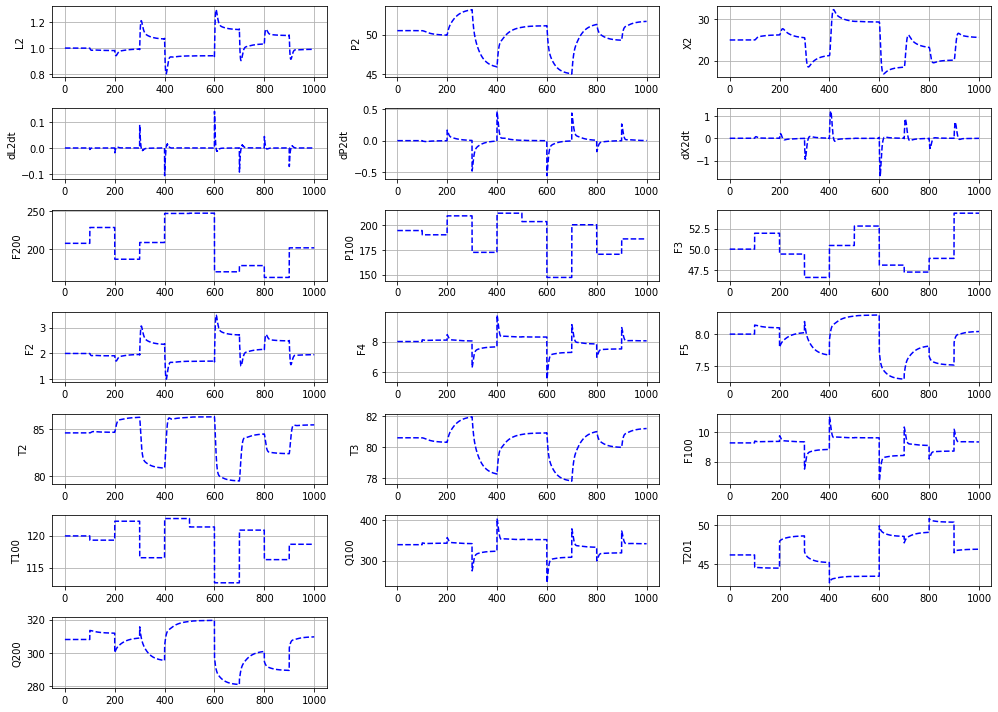

In [7]:
ctr = 1
plt.figure(figsize=(14, 10))
for k in evap_df.columns:
    plt.subplot(7, 3, ctr)
    plt.plot(evap_df[k].index, evap_df[k].values,'b--')
    plt.ticklabel_format(useOffset=False, style='plain')
    plt.grid()
    plt.ylabel(k)
    ctr += 1
    
plt.tight_layout()
plt.show()

In [5]:
evap_df.head(10)

,L2,P2,X2,dL2dt,dP2dt,dX2dt,F200,P100,F3,F2,F4,F5,T2,T3,F100,T100,Q100,T201,Q200
0.000000,1.000000,50.500000,25.000000,-0.000040,0.000297,0.000000,208.000000,194.700000,50.000000,2.000000,8.000803,7.999617,84.605800,80.603500,9.269262,119.944860,339.254976,46.152833,307.985251
0.155051,1.002286,50.488125,25.001502,-0.000123,0.000928,-0.000150,208.000000,194.700000,50.000000,2.000000,8.002462,7.998751,84.599601,80.597479,9.270888,119.944860,339.314490,46.150543,307.951903
0.644949,0.995829,50.521302,24.994819,-0.000473,-0.000784,-0.013767,208.000000,194.700000,50.000000,2.011431,7.998036,8.001171,84.616144,80.614300,9.266549,119.944860,339.155678,46.156942,308.045071
1.000000,1.010365,50.443348,24.995830,0.095889,-0.509394,0.026480,229.518937,145.706370,49.760840,1.979146,6.103084,8.140662,84.572681,80.574778,7.272394,112.409640,266.169606,44.507602,313.415480
1.155051,1.022275,50.375920,24.981843,0.091692,-0.505328,-0.062921,229.518937,145.706370,49.760840,2.051827,6.114342,8.135654,84.530441,80.540591,7.283429,112.409640,266.573494,44.495602,313.222687
1.644949,1.072617,50.101193,24.950036,0.086525,-0.489284,-0.133946,229.518937,145.706370,49.760840,2.111376,6.158116,8.115251,84.366211,80.401305,7.326334,112.409640,268.143814,44.446710,312.437177
2.000000,1.087043,50.002216,24.854977,-0.019603,-0.001572,-0.436721,218.276338,192.282620,50.231560,2.363085,8.028977,8.035264,84.280910,80.351123,9.292685,119.573067,340.112266,45.246790,309.357661
2.155051,1.082906,50.004968,24.774499,-0.023527,-0.000037,-0.516563,218.276338,192.282620,50.231560,2.435216,8.035317,8.035467,84.257299,80.352519,9.298902,119.573067,340.339810,45.247300,309.365461
2.644949,1.072720,49.998339,24.532232,-0.023559,0.005418,-0.461688,218.276338,192.282620,50.231560,2.414528,8.056650,8.034979,84.177843,80.349158,9.319823,119.573067,341.105530,45.246071,309.346676
3.000000,1.061200,50.019538,24.381553,-0.044223,0.131040,-0.381414,212.488318,215.577039,47.505206,2.363601,8.520862,7.996700,84.142646,80.359906,9.807460,123.155749,358.953039,45.698479,307.872956


In [6]:
evap_df.tail(10)

,L2,P2,X2,dL2dt,dP2dt,dX2dt,F200,P100,F3,F2,F4,F5,T2,T3,F100,T100,Q100,T201,Q200
997.000000,0.912710,50.937241,25.752935,0.045327,-0.190997,0.503019,251.841202,192.710781,48.236137,1.550876,7.542575,8.306561,85.086722,80.825181,8.796443,119.638918,321.949830,43.140830,319.802598
997.155051,0.917952,50.918463,25.825357,0.044851,-0.191429,0.481040,251.841202,192.710781,48.236137,1.563548,7.539428,8.305144,85.098816,80.815661,8.793365,119.638918,321.837142,43.137737,319.748061
997.644949,0.944404,50.795094,26.057677,0.043584,-0.189320,0.428728,251.841202,192.710781,48.236137,1.589760,7.538559,8.295838,85.102155,80.753113,8.792514,119.638918,321.806030,43.117411,319.389745
998.000000,0.948521,50.798507,26.181027,-0.030662,0.273098,0.245789,180.864655,209.086404,53.135450,1.722019,8.891224,7.798830,85.142630,80.754843,10.216174,122.157489,373.911960,48.715837,300.254964
998.155051,0.944569,50.834291,26.216287,-0.031255,0.270281,0.215767,180.864655,209.086404,53.135450,1.742606,8.882493,7.801368,85.173749,80.772986,10.207585,122.157489,373.597606,48.723554,300.352668
998.644949,0.927263,50.981628,26.320042,-0.028651,0.259590,0.232733,180.864655,209.086404,53.135450,1.722845,8.850178,7.811817,85.288928,80.847686,10.175795,122.157489,372.434115,48.755328,300.754947
999.000000,0.923576,51.031415,26.419126,0.013528,-0.016768,0.338499,225.714114,194.877313,51.974004,1.636316,8.093123,8.160193,85.347861,80.872927,9.380567,119.972131,343.328737,44.884030,314.167439
999.155051,0.925813,51.028740,26.474520,0.014668,-0.017808,0.358367,225.714114,194.877313,51.974004,1.617882,8.088762,8.159995,85.363675,80.871571,9.376282,119.972131,343.171927,44.883548,314.159814
999.644949,0.933122,51.019221,26.645454,0.014772,-0.020947,0.329644,225.714114,194.877313,51.974004,1.629063,8.075503,8.159290,85.411763,80.866745,9.363254,119.972131,342.695093,44.881830,314.132677
1000.000000,0.938151,51.011441,26.753175,0.013348,-0.022823,0.271985,225.714114,194.877313,51.974004,1.665608,8.067423,8.158714,85.441068,80.862801,9.355315,119.972131,342.404518,44.880426,314.110498


In [8]:
evap_df.to_csv('evap_seed3_valid.csv') 